# NVAR Temporal Subsampling

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

In [2]:
plt.style.use("./rc-gfd.mplstyle")

In [3]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [17]:
delta_t0 = 300
n_samples = 10
n_overlap = 1

dslist0=[] 
for n_lag in [0,1]:
    dslist = []
    for n_sub in [1, 16]: #[1,2,4,8,16]:
        delta_t = n_sub * delta_t0
        fname = '/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/aws-resolution-results/nvar-temporal-sampling-128n/'
        fname += f'validation-{n_samples:03d}samples/{delta_t:04d}dt-lag{n_lag:02d}-nb{n_overlap:02d}/results.zarr/'
        tmp = xr.open_zarr(fname, chunks={"x": 16, "y":16})
        #tmp = tmp.rename({"truth":"pp"}).rename({"prediction":"truth"}).rename({"pp":"prediction"})
        tmp = tmp.expand_dims({'n_sub': [n_sub], 'n_lag': [n_lag]})
        dslist.append(tmp)

    dslist0.append(xr.concat(dslist, dim='n_sub'))
ds = xr.concat(dslist0, dim='n_lag')
ds.attrs['keep_spinup'] = 'False'
ds.attrs['spinup_steps_predict'] = 0

In [18]:
ds["truth"] = ds["truth"].isel(n_sub=0)
ds["error"] = ds["prediction"] - ds["truth"]

In [19]:
ds["absolute_error"] = np.abs(ds["error"])

In [12]:
class BigPlot():
    
    z = 0
    vmax = 15
    vmin = -15
    time = 4800 * np.array([1, 3, 6])
    cmap = "cmo.balance"
    levels = 100
    n_cticks = 7
    
    prediction = "prediction"
    cbar_label=r"Potential Temperature Anomaly ($^\circ$C)"
    
    subplot_kw = {
        "figsize" :(14,18),
        "constrained_layout": True,
    }
    
    diff_t0 = True
    plot_truth = True
    
    @property
    def cticks(self):
        return np.linspace(self.vmin, self.vmax, self.n_cticks)
    
    
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
            
        
    
    def __call__(self, xds, **kwargs):
    
        nrows = len(xds["n_sub"])
        nrows = nrows + 1 if self.plot_truth else nrows
        ncols = len(self.time)
        self.p_start = 1 if self.plot_truth else 0
        
        fig, axs = plt.subplots(nrows, ncols, **self.subplot_kw)
        
        mappables = []
        
        # truth 
        if self.plot_truth:
            m = self._row_plot(xds["truth"], axr=axs[0,:])
            mappables.append(m)

        # now predictions, for each n_sub value
        for n_sub, axr in zip(xds.n_sub, axs[self.p_start:,:]):
            m = self._row_plot(xds[self.prediction], axr=axr, n_sub=n_sub)
            mappables.append(m)
            
        self._add_titles(axs)
        cbar = self._add_colorbar(fig, axs, mappables)
            
        return fig, axs
                
    def _row_plot(self, xda, axr, n_sub=None):
        
        if self.diff_t0:
            with xr.set_options(keep_attrs=True):
                diff = xda - xda.isel(time=0)
        else:
            diff = xda
                
        mappables = []
        for t, ax in zip(self.time, axr):
            
            plotme = diff.sel(z=self.z, time=t)
            plotme = plotme.sel(n_sub=n_sub) if n_sub is not None else plotme
            
            p = plotme.plot.contourf(
                ax=ax,
                add_colorbar=False,
                cmap=self.cmap,
                vmax=self.vmax,
                vmin=self.vmin,
                levels=self.levels)
            
            mappables.append(p)
            
            ax.set(xlabel="",ylabel="",title="",xticks=[],yticks=[])
            for key in ["bottom", "left"]:
                ax.spines[key].set_visible(False)
        
        label = xda.name.capitalize()
        if "truth" not in xda.name:
            label += "\n"
            label += r"$N_{sub}$ = %d" % int(n_sub)
            
        axr[0].set(ylabel=label)
            
        return mappables
    
    def _add_colorbar(self, fig, axs, mappables):
        
        cbar = fig.colorbar(
            mappables[self.p_start][-1],
            ax=axs,
            label=self.cbar_label,
            orientation="horizontal",
            pad=0.02,
            aspect=30,
            shrink=0.9,
            ticks=self.cticks,
        )
        cbar.ax.minorticks_off()
        return cbar
    
    def _add_titles(self, axs):
        for t, ax in zip(self.time, axs[0,:]):
            ax.set(title=r"$t = t_0 +$ %1.2f hours" % float(t/3600))

In [48]:
xds = ds.sel(n_lag=1, n_sub=[1,16], sample=1)

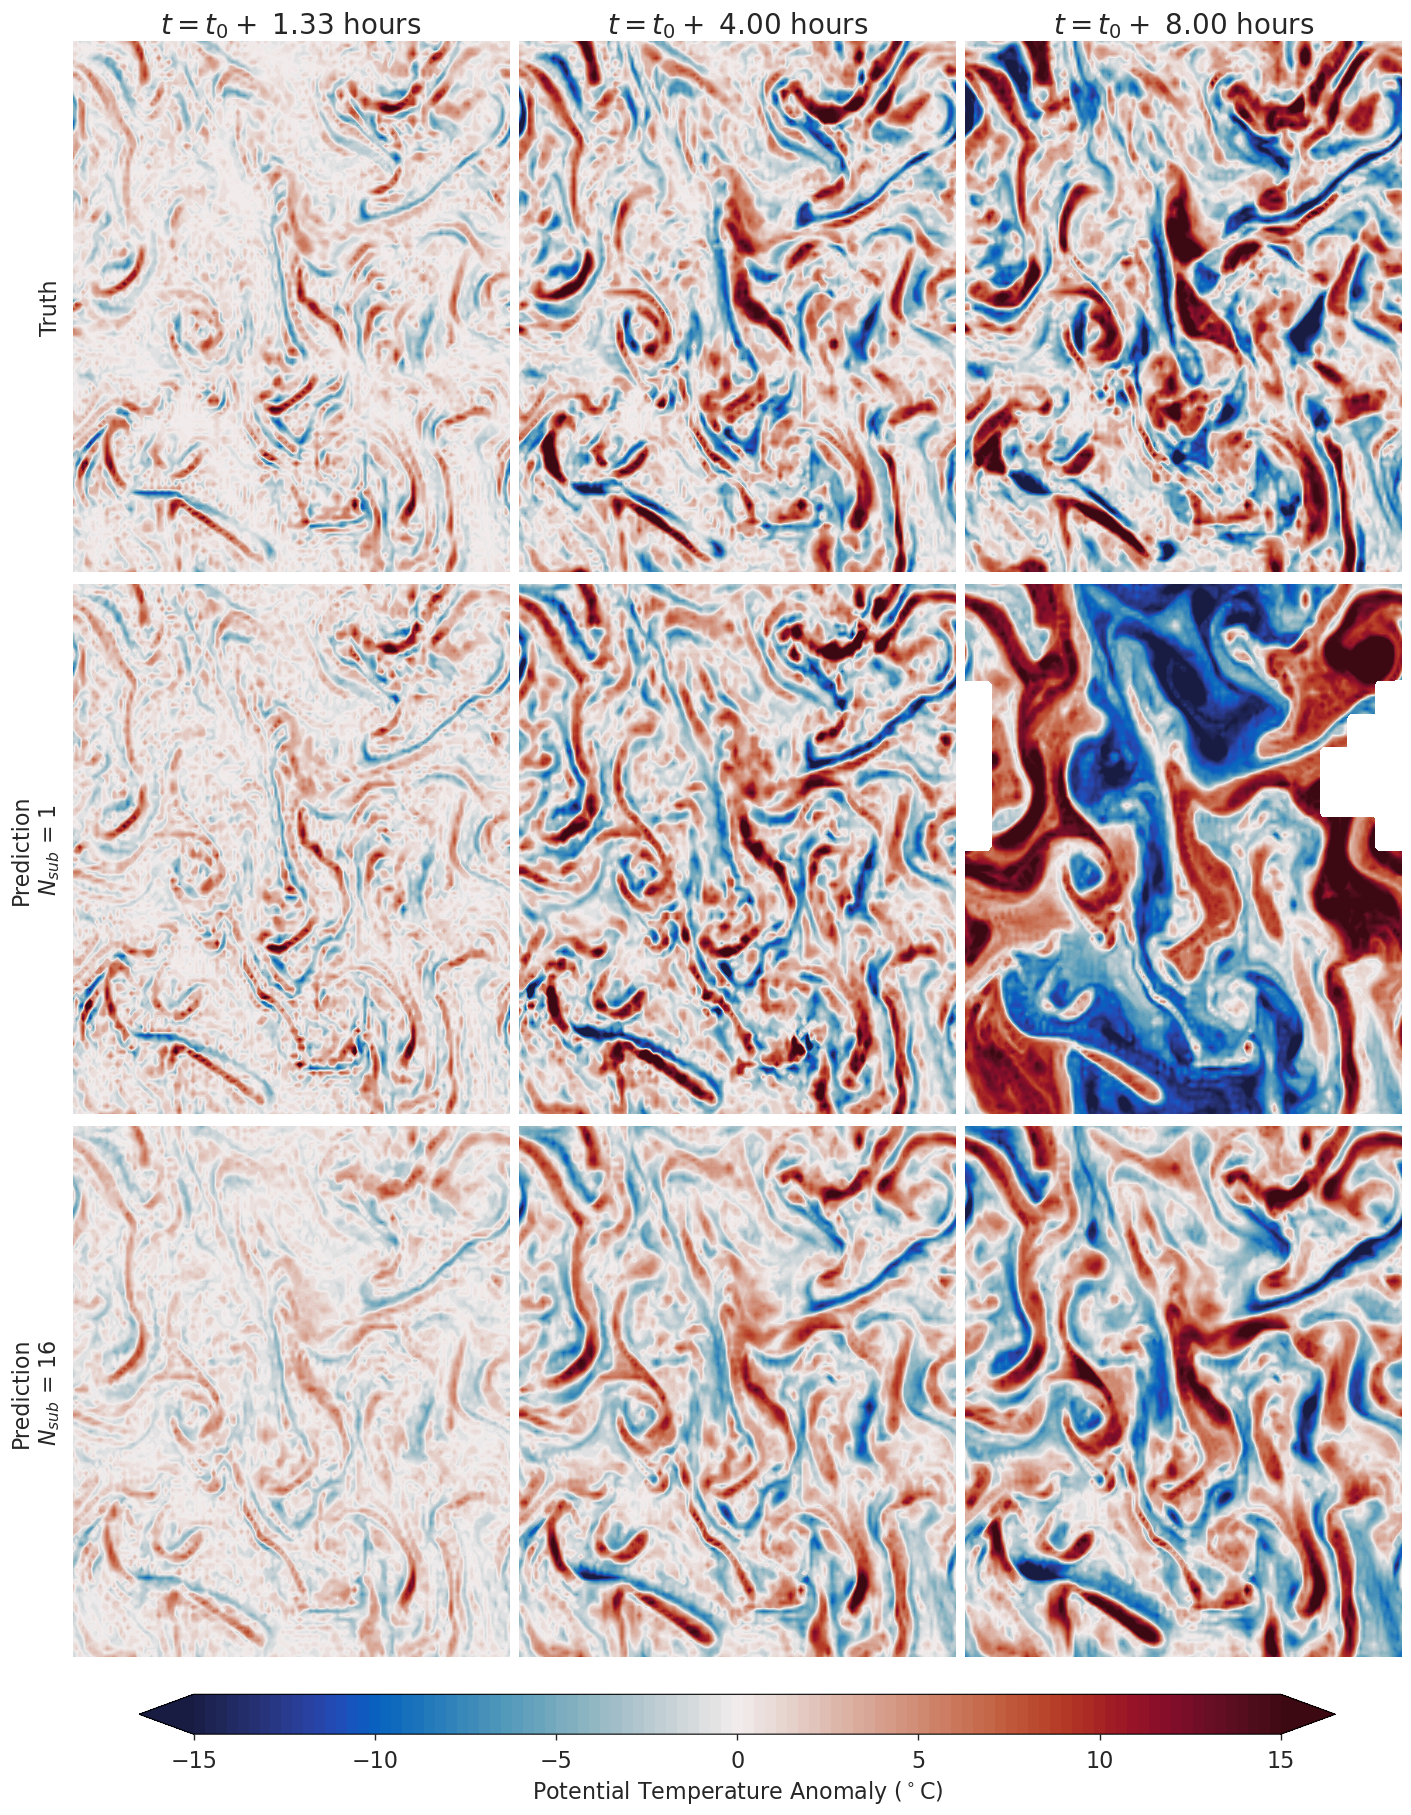

In [49]:
bp = BigPlot()
fig, axs = bp(xds)

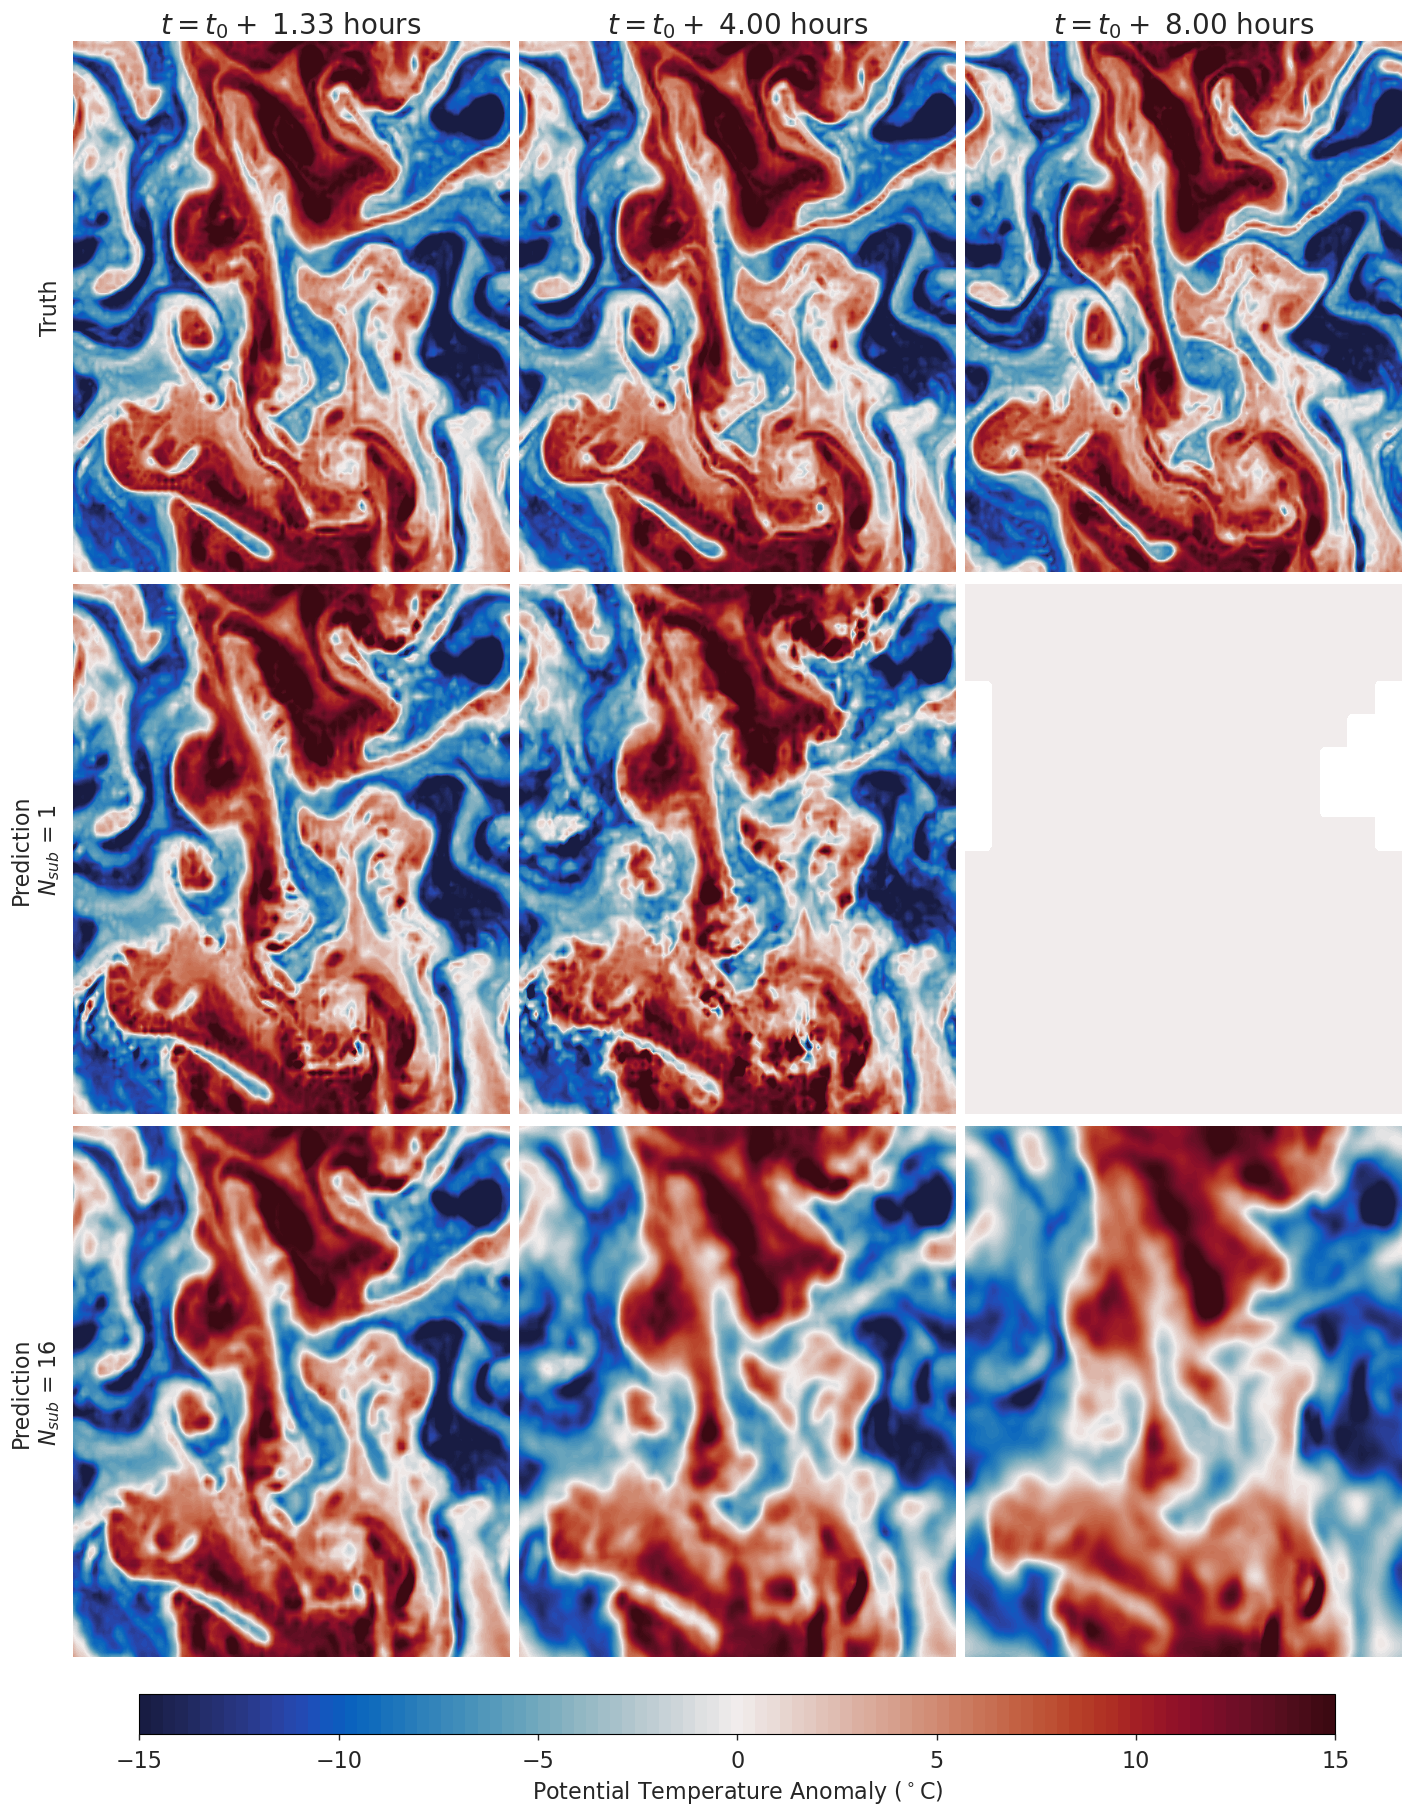

In [50]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds)

In [36]:
ep = BigPlot(prediction="absolute_error",
             cbar_label=r"Absolute Error ($^\circ C$)",
             cmap="viridis",
             plot_truth=False,
             vmax=10,
             vmin=0,
             subplot_kw={
                 "figsize":(14,14),
                 "constrained_layout": True,
             }
            )

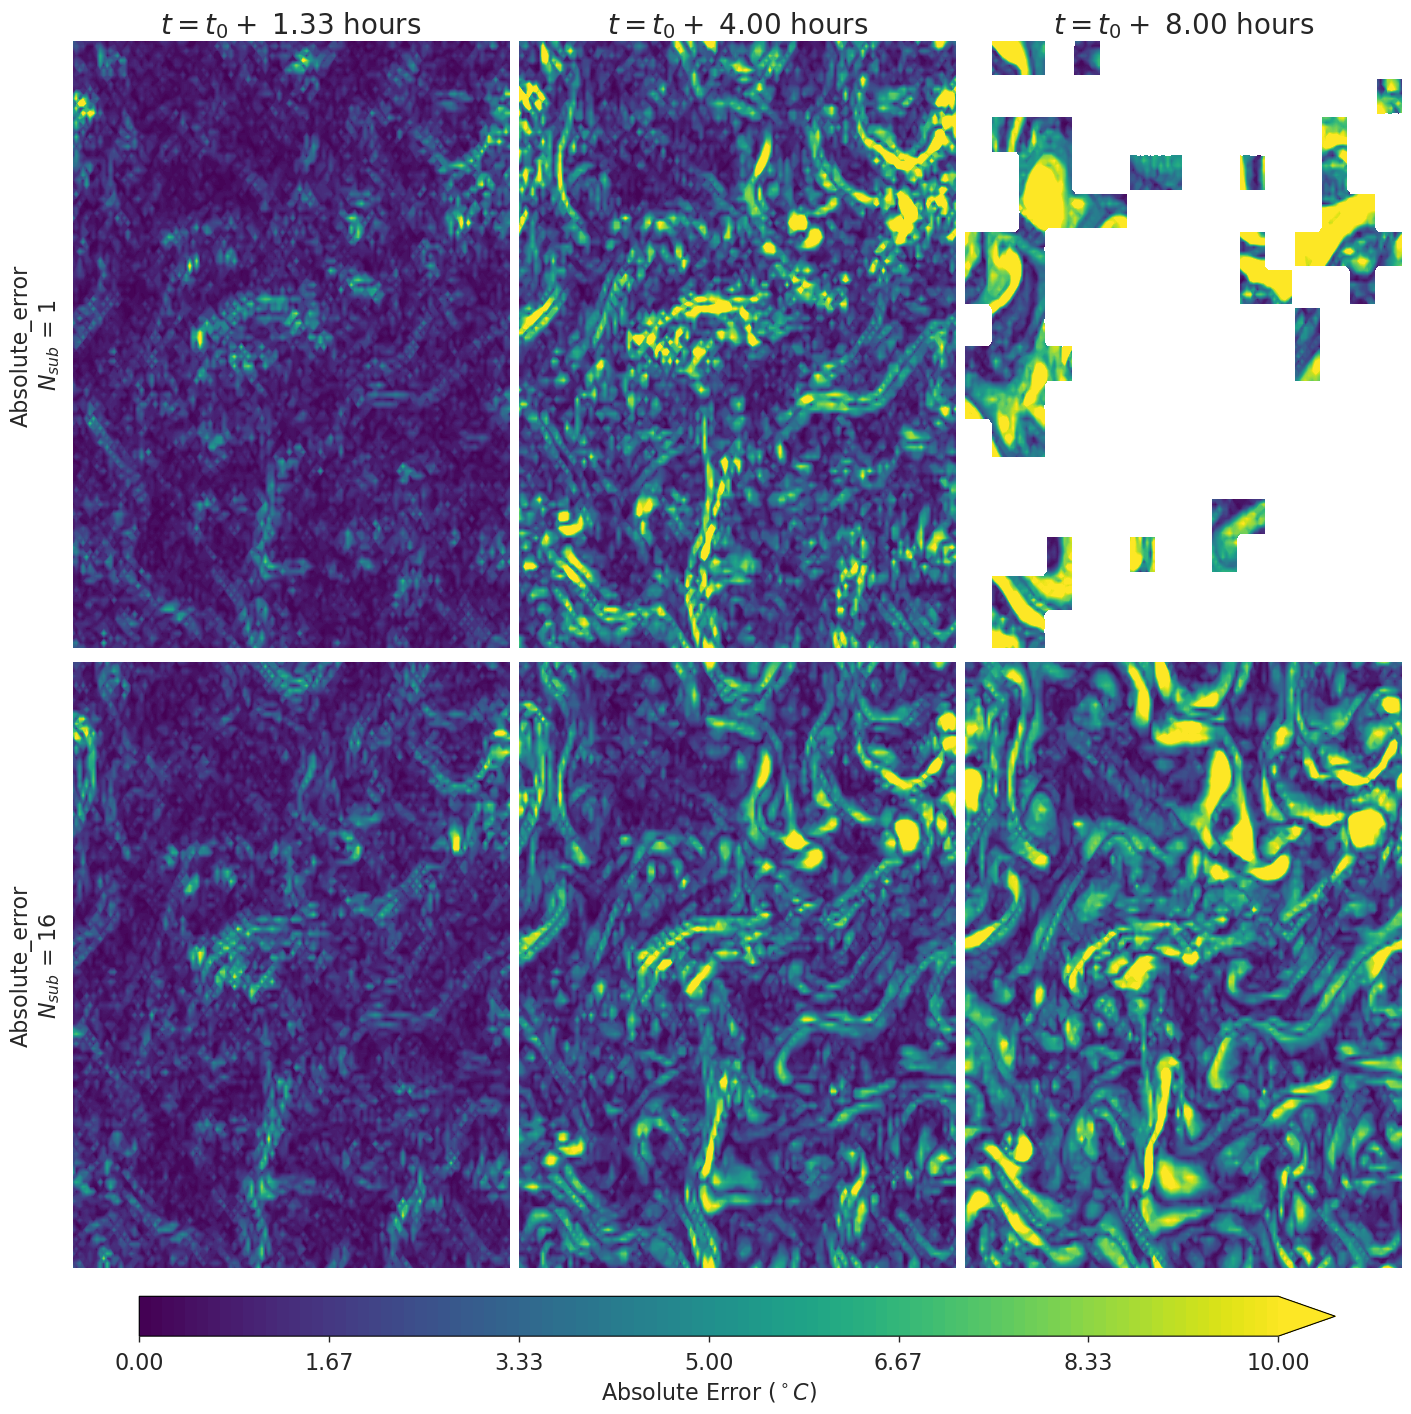

In [37]:
fig, axs = ep(xds)

## Histograms

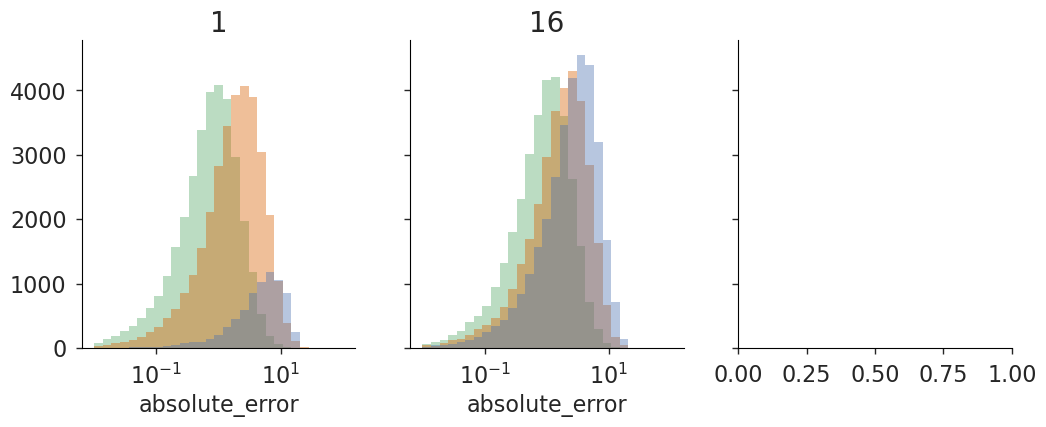

In [38]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

#bins = np.linspace(-50,50,30)
bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,16], axs):
    for t in bp.time:
        plotme = xds.absolute_error.sel(n_sub=n_sub).sel(time=t)
        plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=n_sub)
        
    ax.set(xscale='log')

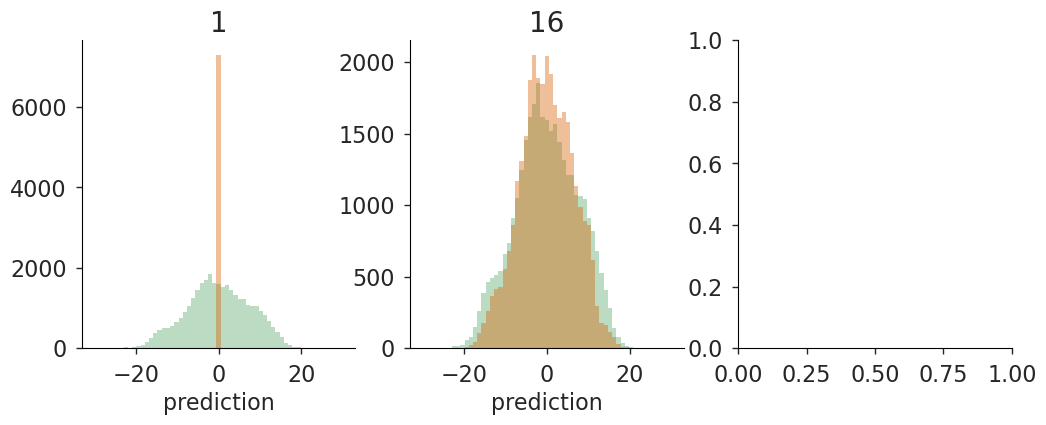

In [39]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

bins = np.linspace(-30,30,60)
#bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,16], axs):
    t = bp.time[-1]
    for key in ["truth", "prediction"]:
        plotme = xds[key].sel(time=t)
        if "truth" not in key:
            plotme = plotme.sel(n_sub=n_sub)
        plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=n_sub)
        
    #ax.set(xscale='log')

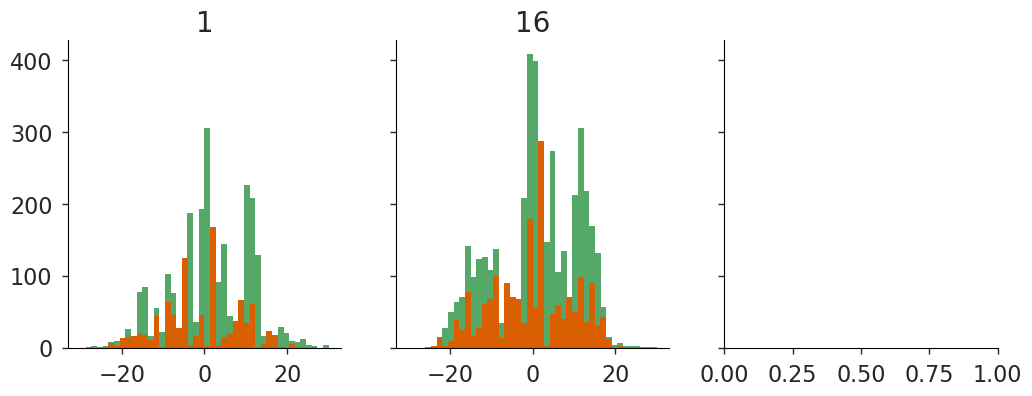

In [45]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

bins = np.linspace(-30,30,45)
#bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,16], axs):
    for t in bp.time[::-1][1:]:
        bdict = {}
        for key in ["truth", "prediction"]:
            plotme = xds[key].sel(time=t)
            if "truth" not in key:
                plotme = plotme.sel(n_sub=n_sub)
            bdict[key], *_ = np.histogram(plotme, bins=bins);
            bc = .5*bins[:-1] + .5*bins[1:]
            
        eb = bdict["prediction"] - bdict["truth"]
        eb = np.abs(eb)
        ax.bar(bc, eb, width=1.4)
    ax.set(title=n_sub)